In [1]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import sys
import numpy as np
import glob
import torch

sys.path.insert(1,"/home/showalte/research/prob_seq_queries/")
from seq_queries.utils import read_pkl, write_pkl

# Estimate fields
- ground_truth/beam_search_lb
- Importance sampling estimate
- Hybrid estimate
- Importance sampling variance
- Hybrid variance

# General Metadata
- dataset_name
- experiment_name
- history_id
- Excluded term
- sequence_length
- history_length
- total_sequence_length

# Sampling metadata
- num_mc_samples (sub_estimates)
- sample_model_iters

# Hybrid data
- hybrid_model_iters

# Beam search metadata
- min_variance
- search_model_iters
- min_variance_reduction
- true_coverage
- restricted_coverage
- num_beams
- top_k
- top_p
- (beam search) interpolation_func


In [2]:

def get_experiment_data(experiment, dataset, h, s, root="../data", 
            methods=['beam_search_is_hybrid','importance_sampling','random_sampling','beam_search'],
            gt_methods=['ground_truth','beam_search']):
    
        data_dict = {}
        gt_type=None
        for method in methods:
            template_path=root + f"/{method}/{dataset}/{experiment}/"
            template_file=(f"{experiment.replace('_','-')}_{dataset.replace('_','-')}_"
            + f"{method.replace('_','-')}_{h}h_{s}s*{'' if method == 'beam_search_is_hybrid' else 'model-budget'}.pkl")
            pot_pattern = os.path.join(template_path,template_file)
            pot_paths = glob.glob(pot_pattern)
            assert len(pot_paths) == 1,\
                f"Found {len(pot_paths)} paths for {pot_pattern}"
            # print(method,pot_paths[0])
            print(method, "\n",pot_paths[0],"\n=============")
            data_dict[method]= read_pkl(pot_paths[0])
            data_dict[method]['metadata']['result_filepath'] = pot_paths[0]
        for gt_method in gt_methods:
            try:
                template_path=root + f"/{gt_method}/{dataset}/{experiment}/"
                template_file=(f"{experiment.replace('_','-')}_{dataset.replace('_','-')}_" +
                               f"{gt_method.replace('_','-')}_{h}h_{s}s*.pkl")
                pot_pattern = os.path.join(template_path,template_file)
                pot_paths = glob.glob(pot_pattern)
                assert len(pot_paths) == 1,\
                    f"Found {len(pot_paths)} paths for {pot_pattern}"
                print("GT: ", gt_method, "\n",pot_paths[0],"\n=============")
                data_dict[gt_method]= read_pkl(pot_paths[0])
                data_dict[gt_method]['metadata']['result_filepath'] = pot_paths[0]
                data_dict['gt_type'] = gt_method
                return data_dict
            except: pass
        assert False,"Could not find ground truth"
        return None
                

In [3]:
def flatten_search(samp_dict,sub_estimates,search_type="beam_search"):
    samp_estimates = samp_dict['bs_lower_bound'][:,:len(sub_estimates)]
    if not sub_estimates:
        if len(samp_estimates.shape) ==3:
            samp_estimates = torch.gather(samp_estimates.mean(dim=1),1,
                                          samp_dict['excluded_terms'].unsqueeze(-1)).squeeze()
            assert len(samp_estimates.shape) == 1,f"Shape of bs_lower_bounds is {len(samp_estimates.shape)}"
        if len(samp_estimates.shape) ==2:
            samp_estimates = torch.gather(samp_estimates,1,
                                              samp_dict['excluded_terms'].unsqueeze(-1)).squeeze()
        
        df = pd.DataFrame(samp_estimates)
        df[f'{sample_type}_model_iters'] = samp_dict['model_iters']
        df[f'{sample_type}_num_beams'] = samp_dist['sample_estimate_var']
        
    else:
        assert samp_estimates.shape[1] == len(sub_estimates),\
        ("Importance sampling estimates and sub_estimates are not aligned in shape." +
         f"got sample_est: {samp_estimates.shape[1]} and sub_estimates: {len(sub_estimates)}")
        if len(samp_estimates.shape) == 2:
            samp_estimates = pd.DataFrame(samp_estimates,columns=sub_estimates)
            print(samp_dict['num_beams'].shape)
            beams = pd.DataFrame(samp_dict['num_beams'][:,:len(sub_estimates)],columns=sub_estimates)
            true_cov = pd.DataFrame(samp_dict['true_coverage'][:,:len(sub_estimates)],columns=sub_estimates)
            restr_cov = pd.DataFrame(samp_dict['restricted_coverage'][:,:len(sub_estimates)],columns=sub_estimates)
            model_iters = pd.DataFrame(samp_dict['model_iters'][:,:len(sub_estimates)],columns=sub_estimates)
            
            df_list = [
                (f'{search_type}_lb',samp_estimates),
                ('model_iters',model_iters),
                ('num_beams',beams),
                ('true_coverage',true_cov),
                ('restricted_coverage',restr_cov),
            ]
            
            for i,(name,df) in enumerate(df_list):
                df = pd.melt(df,value_vars=sub_estimates)
                df.columns = ['num_samples',name]
            df = df_list[0]
            for name,df in df_list[1:]:
                df[f'{search_type}_{name}']=df[name]
            
            # df[f'{sample_type}_variance']=var_df['variance']
            
        elif len(samp_estimates.shape) == 3:
            df_list = []
            for i in range(len(sub_estimates)):
                df = pd.DataFrame(
                            torch.gather(samp_estimates[:,i],1,
                                      samp_dict['excluded_terms'].unsqueeze(-1)).squeeze()
                        )
                df[f'{search_type}_model_iters'] = samp_dict['model_iters'][:,i]
                df[f'{search_type}_num_beams'] = samp_dict['num_beams'][:,i]
                df[f'{search_type}_true_coverage'] = samp_dict['true_coverage'][:,i]
                df[f'{search_type}_restricted_coverage'] = samp_dict['restricted_coverage'][:,i]
                df_list.append(df)
            df = pd.concat(df_list,axis=0,ignore_index=True)
        else:
            assert False,f"Shape of samp_estimates is {len(samp_estimates.shape)}"
    res_cols = ['lb','model_iters','num_beams','true_coverage','restricted_coverage']
    assert df.shape[-1] == len(res_cols), f"DF shape is {df.shape}"
    df.columns = [f'{search_type}_{s}' for s in res_cols]
    return df



def flatten_sampling(samp_dict,sub_estimates,sample_type="importance"):
    samp_estimates = samp_dict['sample_estimates'][:,:len(sub_estimates)]
    if not sub_estimates:
        if len(samp_estimates.shape) ==3:
            assert samp_estimates.shape[1] == samp_dict['metadata']['num_mc_samples'],\
            (f"Error, estimate dimensions are {samp_estimates.shape} but the number of samples is " +
             f"{samp_dict['metadata']['num_mc_samples']}, which does not match")
            
            samp_estimates = torch.gather(samp_estimates.mean(dim=1),1,
                                          samp_dict['excluded_terms'].unsqueeze(-1)).squeeze()
            assert len(samp_estimates.shape) == 1,f"Shape of imp_samp_estimates is {len(samp_estimates.shape)}"
        if len(samp_estimates.shape) ==2:
            samp_estimates = torch.gather(samp_estimates,1,
                                              samp_dict['excluded_terms'].unsqueeze(-1)).squeeze()
        
        df = pd.DataFrame(samp_estimates)
        df.insert(0,'num_mc_samples',samp_dict['metadata']['num_mc_samples'])
        df[f'{sample_type}_model_iters'] = samp_dict['model_iters']
        df[f'{sample_type}_est_variance'] = samp_dist['sample_estimate_var']
        
    else:
        assert samp_estimates.shape[1] == len(sub_estimates),\
        ("Importance sampling estimates and sub_estimates are not aligned in shape." +
         f"got sample_est: {samp_estimates.shape[1]} and sub_estimates: {len(sub_estimates)}")
        if len(samp_estimates.shape) == 2:
            samp_estimates = pd.DataFrame(samp_estimates,columns=sub_estimates)
            samp_var = pd.DataFrame(samp_dict['sample_estimate_var'][:,:len(sub_estimates)],columns=sub_estimates)
            model_iters = pd.DataFrame(samp_dict['model_iters'][:,:len(sub_estimates)],columns=sub_estimates)
            sub_estimate_num_samples = None
            if sample_type != 'hybrid':
                sub_estimate_num_samples = pd.DataFrame(samp_dict['num_mc_samples'][:,:len(sub_estimates)],columns=sub_estimates)
            
            df_list = [
                (f'{sample_type}_sampling_est',samp_estimates),
                ('num_mc_samples',sub_estimate_num_samples),
                ('model_iters',model_iters),
                ('variance',samp_var),
            ]
            
            for i,(name,df) in enumerate(df_list):
                if name == 'num_mc_samples' and sample_type=="hybrid": continue
                df = pd.melt(df,value_vars=sub_estimates)
                df.columns = ['num_samples',name]
            df = df_list[0]
            for name,df in df_list[1:]:
                if name == 'num_mc_samples' and sample_type=="hybrid": continue
                df[f'{sample_type}_{name}']=df[name]
            if df_type == "hybrid":
                df['num_mc_samples'] = df['num_samples']
                df = df[['num_mc_samples',f'{sample_type}_sampling_est',
                         'model_iters','variance']]
            
            # df[f'{sample_type}_variance']=var_df['variance']
            
        elif len(samp_estimates.shape) == 3:
            df_list = []
            for i in range(len(sub_estimates)):
                df = pd.DataFrame(
                            torch.gather(samp_estimates[:,i],1,
                                      samp_dict['excluded_terms'].unsqueeze(-1)).squeeze()
                        )
                if sample_type == "hybrid": df.insert(0,'num_mc_samples',sub_estimates[i])
                else: df.insert(0,'num_mc_samples',samp_dict['num_mc_samples'][:,i])
                df[f'{sample_type}_model_iters'] = samp_dict['model_iters'][:,i]
                samp_est_var = torch.gather(samp_dict['sample_estimate_var'][:,i],1,
                                            samp_dict['excluded_terms'].unsqueeze(-1)).squeeze()
                                            
                df[f'{sample_type}_variance'] = samp_est_var
                
                df_list.append(df)
            df = pd.concat(df_list,axis=0,ignore_index=True)
        else:
            assert False,f"Shape of samp_estimates is {len(samp_estimates.shape)}"
    res_cols = ['num_mc_samples','sampling_est','model_iters','variance']
    assert df.shape[-1] == len(res_cols), f"DF shape is {df.shape}"
    df.columns = [f'{sample_type}_{s}' for s in res_cols]
    return df


def flatten_gt(data_dict,gt_type):
    gt_dict = data_dict[gt_type]
    # gt = gt_dict['bs_lower_bound']
    gt = torch.gather(gt_dict['bs_lower_bound'],1,
                      gt_dict['excluded_terms'].unsqueeze(-1)).squeeze()
    assert len(gt.shape) == 1,\
    f"Ground truth has {len(gt.shape)} dimensions"
    df = pd.DataFrame(gt,columns=['ground_truth'])
    for item in ['true_coverage','restricted_coverage','model_iters']:
        df[f"gt_{item}"] = [gti.item() for gti in gt_dict[item]]
    # df["gt_model_iters"] = gt_dict['model_iters']
    df['is_gt'] = int(gt_type == 'ground_truth')
    df['gt_num_beams'] = gt_dict['metadata']['num_beams']
    
    return df
    

def flatten_experiment(data_dict,experiment, dataset,h,s,
     global_agreement_vals= ['excluded_terms']):
    sub_estimates = sorted(list(
        # set(data_dict['importance_sampling']['metadata']['sub_estimates']) &
        # set(data_dict['random_sampling']['metadata']['sub_estimates']) &
        set(data_dict['beam_search_is_hybrid']['metadata']['sub_estimates'])))
    sub_est_len = 1 if not sub_estimates else len(sub_estimates)
    
    importance_df = flatten_sampling(data_dict['importance_sampling'],sub_estimates,sample_type ='importance')
    random_df = flatten_sampling(data_dict['random_sampling'],sub_estimates,sample_type ='random')
    hybrid_df = flatten_sampling(data_dict['beam_search_is_hybrid'],sub_estimates,sample_type ='hybrid')
    search_df = flatten_search(data_dict['beam_search'],sub_estimates,search_type='beam_search')
    # hybrid_df.drop("num_mc_samples",inplace = True,axis=1)
    
    gt_df = flatten_gt(data_dict,data_dict['gt_type'])
    gt_df = pd.concat([gt_df]*sub_est_len,axis=0,ignore_index=True)
    final_df = pd.concat([random_df,importance_df,hybrid_df,search_df,gt_df],axis=1)
    
    # Metadata checks
    is_metadata = ['top_k','top_p']
    hybrid_metadata = ['min_variance','min_var_reduction']
    bs_metadata = []
    gt_metadata = []
    for m in is_metadata:
        final_df['is_' + m] = int(data_dict['importance_sampling']['metadata'][m])
    for m in hybrid_metadata:
        final_df['hybrid_' + m] = float(data_dict['beam_search_is_hybrid']['metadata'][m])
    for m in bs_metadata:
        final_df['bs_lb_' + m] = data_dict['beam_search']['metadata'][m]
    for m in bs_metadata:
        final_df['gt_' + m] = data_dict[data_dict['gt_type']]['metadata'][m]
    # final_df['interp_func'] = str(data_dict[data_dict['gt_type']]['metadata']['interp_func']).split(" ")[1]
    
    
    final_df['dataset_name'] = dataset
    final_df['hist_len'] = h
    final_df['total_seq_len'] = s
    final_df['num_steps'] = s-h
    sequence_ids = list(range(data_dict['importance_sampling']['sample_estimates'].shape[0]))*sub_est_len
    excluded_terms = data_dict['importance_sampling']['excluded_terms'].numpy().tolist()*sub_est_len
    final_df['sequence_id'] = sequence_ids
    final_df['excluded_term'] = excluded_terms
    final_df['is_lin_interp'] = 1
                 
    # ==== Phase shift stuff ====
    # phase_shifts = read_pkl("/srv/disk00/samshow/amazon/amazon_phase_trans.pkl")
    # phase_shift_val_inds = read_pkl("../data/amazon/amazon_val_dl_transition_inds.pkl")
    # phase_shifts = phase_shifts[phase_shift_val_inds].numpy().tolist()
    # print(phase_shift_val_inds.shape, final_df.shape)
    # final_df['phase_shifts'] = phase_shifts * sub_est_len
    # final_df['phase_shifts'] -=1
    
    return final_df
     
    
    

In [4]:
experiment = ["val_dl"]
dataset = ["apps"]
lengths = [(13,15),(12,15)]
def flatten_experiments(experiments, datasets, lengths,model_budget=False):
    data_list = []
    for experiment in experiments:
        for dataset in datasets:
            for h,s in lengths:
                data = get_experiment_data(experiment,dataset,h,s)
                df = flatten_experiment(data,experiment, dataset, h,s)
                    
#                     print(df.head())
#                     print(df.columns)
#                     print(df.shape)
#                     sys.exit(1)
                    
                data_list.append(df)
                    
    # print(len(data_list))
    data_df = pd.concat(data_list,axis = 0)
    ordering = [ 'sequence_id','num_steps', 'excluded_term', 'is_gt','ground_truth',
                'random_sampling_est','importance_sampling_est','hybrid_sampling_est', 'beam_search_lb',
                'random_num_mc_samples', 'importance_num_mc_samples','hybrid_num_mc_samples',
                'gt_model_iters','random_model_iters', #continues to next line
                'importance_model_iters','hybrid_model_iters','beam_search_model_iters',
                'random_variance','importance_variance',  'hybrid_variance',
                'gt_true_coverage', 'gt_restricted_coverage', 'gt_num_beams',
                'beam_search_true_coverage', 'beam_search_restricted_coverage', 'beam_search_num_beams',
                'is_top_k','is_top_p',
                'hybrid_min_variance','hybrid_min_var_reduction', 
                'hist_len', 'total_seq_len']#, 'phase_shifts']
    data_df = data_df[ordering]
    print(data_df.columns)
    
    return data_df
                
                          

In [7]:
# df = flatten_experiments(['val_dl'],['shakespeare'],[(18,20),(17,20)])
# df.to_csv('shakespeare_17-18_20.csv',index=None)
df = flatten_experiments(['val_dl'],['amazon'],[(13,15),(12,15)])
# df.to_csv('amazon_12-13_15.csv',index=None)
# df = flatten_experiments(['val_dl'],['moocs'],[(13,15),(12,15)])
# df.to_csv('moocs_12-13_15.csv',index=None)
# df = flatten_experiments(['val_dl'],['apps'],[(12,15),(13,15)])
# df.to_csv('apps_12-13_15.csv',index=None)


beam_search_is_hybrid 
 ../data/beam_search_is_hybrid/amazon/val_dl/val-dl_amazon_beam-search-is-hybrid_13h_15s_1000mc.pkl 
importance_sampling 
 ../data/importance_sampling/amazon/val_dl/val-dl_amazon_importance-sampling_13h_15s_1000mc_model-budget.pkl 
random_sampling 
 ../data/random_sampling/amazon/val_dl/val-dl_amazon_random-sampling_13h_15s_1000mc_model-budget.pkl 
beam_search 
 ../data/beam_search/amazon/val_dl/val-dl_amazon_beam-search_13h_15s_model-budget.pkl 
GT:  ground_truth 
 ../data/ground_truth/amazon/val_dl/val-dl_amazon_ground-truth_13h_15s.pkl 
beam_search_is_hybrid 
 ../data/beam_search_is_hybrid/amazon/val_dl/val-dl_amazon_beam-search-is-hybrid_12h_15s_1000mc.pkl 
importance_sampling 
 ../data/importance_sampling/amazon/val_dl/val-dl_amazon_importance-sampling_12h_15s_1000mc_model-budget.pkl 
random_sampling 
 ../data/random_sampling/amazon/val_dl/val-dl_amazon_random-sampling_12h_15s_1000mc_model-budget.pkl 
beam_search 
 ../data/beam_search/amazon/val_dl/val-dl_am

In [6]:
df.columns

Index(['sequence_id', 'num_steps', 'excluded_term', 'is_gt', 'ground_truth',
       'random_sampling_est', 'importance_sampling_est', 'hybrid_sampling_est',
       'beam_search_lb', 'random_num_mc_samples', 'importance_num_mc_samples',
       'hybrid_num_mc_samples', 'gt_model_iters', 'random_model_iters',
       'importance_model_iters', 'hybrid_model_iters',
       'beam_search_model_iters', 'random_variance', 'importance_variance',
       'hybrid_variance', 'gt_true_coverage', 'gt_restricted_coverage',
       'gt_num_beams', 'beam_search_true_coverage',
       'beam_search_restricted_coverage', 'beam_search_num_beams', 'is_top_k',
       'is_top_p', 'hybrid_min_variance', 'hybrid_min_var_reduction',
       'hist_len', 'total_seq_len'],
      dtype='object')

In [31]:
# data['importance_sampling']['metadata']['sub_estimates']
# print(df.shape)
# print(df.isnull().sum())
# df.phase_shifts.describe()
# df[['num_steps','gt_model_iters',
    # 'importance_model_iters','hybrid_model_iters','beam_search_model_iters']].tail(10)
# df[['hybrid_num_mc_samples', 'importance_num_mc_samples','beam_search_num_beams']].tail(50)
# df[['beam_search_true_coverage','beam_search_restricted_coverage','beam_search_num_beams']].tail(50)


In [109]:
df.excluded_term.drop_duplicates().shape

(24,)

In [101]:
df.loc[:10,['sequence_id','ground_truth']]

,sequence_id,ground_truth
0,0,0.002659
1,1,0.000014
2,2,0.002855
3,3,0.001897
4,4,0.001897
5,5,0.002891
6,6,0.023775
7,7,0.001066
8,8,0.001873
9,9,0.000010


In [32]:
(df.ground_truth < df.beam_search_lb).sum()

827

In [36]:
test_df= df[ (df.beam_search_num_beams>10)]
test_df= test_df[ (test_df.beam_search_num_beams < 100)]
abs((test_df.beam_search_lb - test_df.ground_truth)/test_df.ground_truth).mean()

0.11905558407306671

In [51]:
2072 - (29 + 841 + 1202)

1202

In [50]:
tdf.loc[12770,:]

sequence_id                            2.000000
num_steps                              3.000000
excluded_term                         23.000000
is_gt                                  1.000000
ground_truth                           0.030245
random_sampling_est                    0.026151
importance_sampling_est                0.030695
hybrid_sampling_est                    0.030626
beam_search_lb                         0.026705
random_num_mc_samples                811.000000
importance_num_mc_samples            811.000000
hybrid_num_mc_samples               1000.000000
gt_model_iters                     25259.000000
random_model_iters                  2433.000000
importance_model_iters              2433.000000
hybrid_model_iters                  2432.000000
beam_search_model_iters             2072.000000
random_variance                        0.000117
importance_variance                    0.000010
hybrid_variance                        0.000005
gt_true_coverage                       0

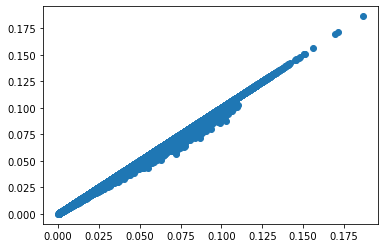

In [21]:
tdf = df[df.hybrid_num_mc_samples > 100]
plt.scatter(tdf.ground_truth, tdf.beam_search_lb)
# tdf[['hybrid_model_iters','beam_search_model_iters']].head()

In [20]:
df.loc[abs(df.hybrid_model_iters - df.importance_model_iters) > 40,
       ['importance_num_mc_samples','hybrid_num_mc_samples',
       'importance_model_iters','hybrid_model_iters']].head()

,importance_num_mc_samples,hybrid_num_mc_samples,importance_model_iters,hybrid_model_iters
16865,764,1000,1528,1728
16866,821,1000,1642,1903
16867,838,1000,1676,1767
16868,949,1000,1898,1655
16869,942,1000,1884,1818


Text(0.5, 1.0, 'importance')

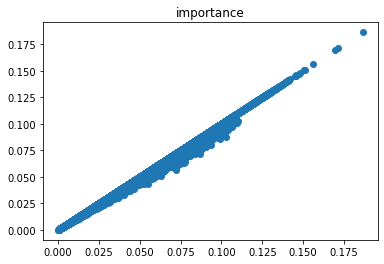

In [16]:
# df = df[df['phase_shifts'] > 10]
# df = df1
ndf = df[df.beam_search_num_beams > 100]
plt.scatter(ndf['ground_truth'],ndf['beam_search_lb'])
# plt.scatter(df['ground_truth'],df['importance_sampling_est'])
# plt.scatter(df['ground_truth'],df['random_sampling_est'])
# plt.ylim((0,1))
plt.title("importance")

In [27]:
df[['importance_est_variance','hybrid_est_variance']].describe()

,importance_est_variance,hybrid_est_variance
count,2.191800e+04,2.191800e+04
mean,3.688037e-05,3.907905e-06
std,6.492985e-04,8.797111e-05
min,2.860333e-20,1.116206e-19
25%,4.422974e-09,1.191007e-09
50%,4.011587e-08,1.700204e-08
75%,3.072154e-07,1.139661e-07
max,4.445925e-02,4.038442e-03


In [21]:
df.isnull().sum()

dataset_name                       0
sequence_id                        0
num_steps                          0
excluded_term                      0
gt_type                            0
ground_truth                       0
random_sampling_est                0
importance_sampling_est            0
hybrid_sampling_est                0
beam_search_lb                     0
random_num_mc_samples              0
importance_num_mc_samples          0
hybrid_num_mc_samples              0
gt_model_iters                     0
random_model_iters                 0
importance_model_iters             0
hybrid_model_iters                 0
beam_search_model_iters            0
random_variance                    0
importance_variance                0
hybrid_variance                    0
gt_true_coverage                   0
gt_restricted_coverage             0
gt_num_beams                       0
beam_search_true_coverage          0
beam_search_restricted_coverage    0
beam_search_num_beams              0
i

In [25]:
# df.to_csv('shakespeare_17-18_20.csv',index=None)
# df.to_csv('moocs_12-13_15.csv',index=None)
# df.to_csv('apps_12-13_15.csv',index=None)
df.to_csv('amazon_12-13_15.csv',index=None)

In [100]:
amazon_dict = read_pkl("/srv/disk00/samshow/amazon/amazon_text_dict.pkl")

In [101]:
data = amazon_dict['text']

In [102]:
data.shape

torch.Size([63844580, 16])

In [109]:
data[0]

tensor([ 0., 16., 16., 16., 11.,  3., 27., 27.,  9.,  9.,  9., 23., 16., 16.,
        16.,  8.])

In [112]:
from tqdm import tqdm
trans = []
for i in tqdm(range(data.shape[0])):
    trans.append(torch.unique_consecutive(data[i,1:]).shape)
    

100%|██████████| 63844580/63844580 [17:23<00:00, 61164.82it/s]  


In [125]:
trans = torch.LongTensor(trans).flatten()

In [126]:
trans.shape

torch.Size([63844580])

In [127]:
write_pkl(trans, "/srv/disask00/samshow/amazon/amazon_phase_trans.pkl")

In [121]:
trans_vals = []
for i in range(1,trans.max()+1):
    trans_vals.append((trans == i).sum().item()/trans.shape[0])

In [123]:
amazon_perc_per_phase_shift = [0.059163910233257073,
 0.020707521296247856,
 0.056485656260876024,
 0.04778584180520884,
 0.07297364944682853,
 0.07653857226408256,
 0.09382401763783238,
 0.10168632952084578,
 0.1102257544806466,
 0.10986890351538063,
 0.09992870185691566,
 0.0774158276238954,
 0.047934671979986396,
 0.020711280425057224,
 0.004749361652939059]